# はじめに
公平な機械学習モデルを構築する手法を検証します。  

### 概要
- 公平性指標としてEqualized Oddsを使用します。  
- Correlation Removerを用いて、公平な機械学習モデルを構築します。

# 公平性指標  
### Equalized Odds  
今回考える公平性指標は、性別や人種などの各グループが公平に扱われているか（group fairness）を評価するために用いられます。  
Equalized Oddsは、positiveとnegativeの2クラス分類において、positiveと判定される確率に着目した指標です。  
具体的には、正しくpositiveと判定される確率（true positive rate）と、誤ってpositiveと判定される確率（false positive rate）がグループによらず等しいかを評価します。  

数式で書くと、性別や人種などの属性の集合を$A$、モデルが予測するクラスの集合を$Y=\{0,1\}$、属性が$a \in A$かつ正解クラスが$y \in Y$のデータが、クラス$\hat{Y} =1$と予測される確率を$P(\hat{Y}=1|A=a, Y=y)$とすると、任意の$y, a, a'$で下記が成り立つ場合、モデルはEqualized Oddsを満たします。

$$
P(\hat{Y}=1|A=a, Y=y) = P(\hat{Y}=1|A=a', Y=y)
$$

# Correlation Remover  
この手法では、モデルの学習に用いるデータから、公平性で考慮する属性との相関を取り除きます。  
元のデータを$\{x_1, ... , x_n\}$、それぞれのデータの公平性で考慮する属性を$\{s_1, ..., s_n\}$、属性の平均を$\bar{s}$とし、相関を取り除いたデータ$\{z_1, ...,z_n\}$を最適化します。  

具体的には、$z$と$s$との相関が0となる下記条件のもとで  
$$
\frac{1}{n} \sum_{i=1}^n z_i (s_i - \bar{s})^T = 0 
$$
$z_i$と$x_i$の距離（L2ノルム）を最小化します。
$$
\min_{z_1, ..., z_n} \sum_{i=1}^n ||z_i - x_i||^2 
$$




# 実装

### 1. ライブラリのインポート
必要なライブラリをインポートします。

In [ ]:
import sys
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import lightgbm as lgb

!pip install fairlearn
from fairlearn.datasets import fetch_adult
from fairlearn.preprocessing import CorrelationRemover
from fairlearn.metrics import equalized_odds_difference, MetricFrame, true_positive_rate, false_positive_rate, count

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 4.8 MB/s eta 0:00:00


### 2. データセットの用意  
今回は[Adult Data Set](http://archive.ics.uci.edu/ml/datasets/adult)を使用します。  
年齢や教育歴などの14の属性から、収入が5万ドルを超えるかどうかを予測するタスクのデータセットで、48,842サンプルが含まれます。  
UCI Machine Learning Repositoryからダウンロードすることもできますが、Fairlearnのfetch_adultで取得します。

データを7:3にランダムに分割して、それぞれを教師データとテストデータとして使用します。  
ラベルは、Fairlearnで用いられるように'>50K'は1、'<=50K'は0となるように変換しておきます。  

In [ ]:
X, y = fetch_adult(return_X_y=True, as_frame=True)
print(X.head())
print(X.shape)
print(set(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
y_train = (y_train == '>50K') * 1
y_test = (y_test == '>50K') * 1

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


    age  workclass    fnlwgt     education  education-num      marital-status  \
0  25.0    Private  226802.0          11th            7.0       Never-married   
1  38.0    Private   89814.0       HS-grad            9.0  Married-civ-spouse   
2  28.0  Local-gov  336951.0    Assoc-acdm           12.0  Married-civ-spouse   
3  44.0    Private  160323.0  Some-college           10.0  Married-civ-spouse   
4  18.0        NaN  103497.0  Some-college           10.0       Never-married   

          occupation relationship   race     sex  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male           0.0           0.0   
1    Farming-fishing      Husband  White    Male           0.0           0.0   
2    Protective-serv      Husband  White    Male           0.0           0.0   
3  Machine-op-inspct      Husband  Black    Male        7688.0           0.0   
4                NaN    Own-child  White  Female           0.0           0.0   

   hours-per-week native-country

### 3. 相関の除去
Correlation Removerは、連続値の特徴にしか適用できないため、データセットから連続値だけ抽出した X_train_fl と、そこから相関を除去した X_cr を作成します。  
属性も数値に変換する必要があるので、性別を整数値に変換しておきます。

In [ ]:
X_train_fl = X_train[['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'sex']]
X_test_fl = X_test[['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']]
X_train_fl.loc[:,'sex'] = (X_train_fl['sex'] == 'Male').astype(int)

cr = CorrelationRemover(sensitive_feature_ids=["sex"])
X_cr = cr.fit_transform(X_train_fl)
X_cr_df = pd.DataFrame(X_cr, columns=['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week'])
X_cr_df['sex'] = X_train_fl['sex']

<ipython-input-38-f027ab455987>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fl.loc[:,'sex'] = (X_train_fl['sex'] == 'Male').astype(int)
<ipython-input-38-f027ab455987>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_train_fl.loc[:,'sex'] = (X_train_fl['sex'] == 'Male').astype(int)


除去前後の特徴間の相関を可視化します。  
除去前は、性別とその他の特徴に相関があるのに対し、除去後には、相関が0になっていることが確認できます。  

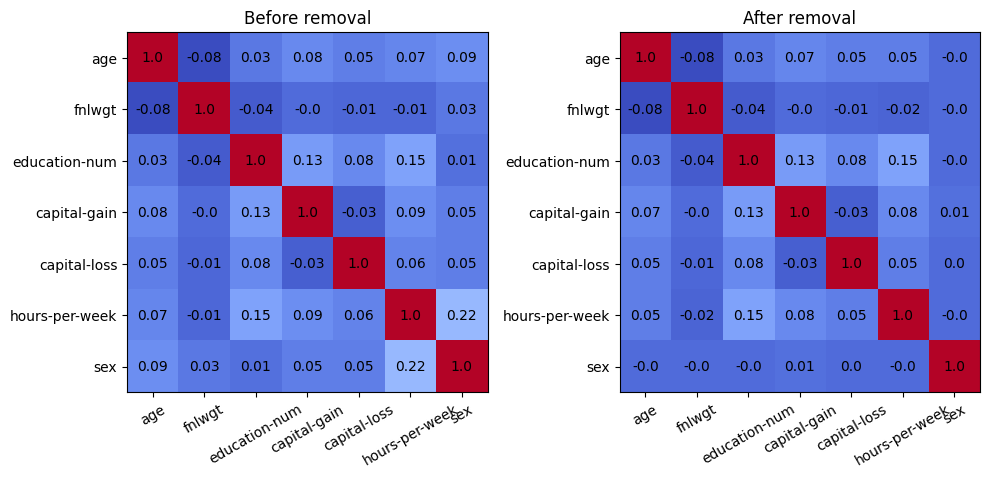

In [ ]:
def draw_heatmap(X, title):
    cols = list(X.columns)
    plt.imshow(round(X.corr(), 2), cmap="coolwarm")
    plt.xticks(np.arange(len(cols)), labels=cols)
    plt.yticks(np.arange(len(cols)), labels=cols)
    plt.xticks(rotation=30)
    for i in range(len(cols)):
        for j in range(len(cols)):
            plt.text(
                j,
                i,
                round(X.corr().to_numpy()[i, j], 2),
                ha="center",
                va="center",
            )
    plt.title(title)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
draw_heatmap(X_train_fl, 'Before removal')

plt.subplot(1,2,2)
draw_heatmap(X_cr_df, 'After removal')

plt.tight_layout()
plt.show()

### 3. 通常の学習  
LightGBMでモデルの学習を行います。  
全ての特徴を用いたモデル、連続値だけ用いたモデル、相関を取り除いた連続値を用いたモデルの3つを構築します。  


In [ ]:
lgb_params = {
    'objective' : 'binary',
}
model = lgb.LGBMClassifier(**lgb_params)
model.fit(X_train, y_train)

model_fl = lgb.LGBMClassifier(**lgb_params)
X_tmp = X_train_fl.drop('sex', axis=1)
model_fl.fit(X_tmp, y_train)

model_cr = lgb.LGBMClassifier(**lgb_params)
model_cr.fit(X_cr, y_train)

LGBMClassifier(objective='binary')

### 6. 公平性評価
モデルの有用性は、今回はF1スコアをsklearn.metrics.f1_scoreで計算します。  
公平性指標はEqualized OddsをFairlearnのequalized_odds_differenceで計算します。  
この関数は、sensitive_featuresに指定した属性のグループ間のtrue positive rateまたはfalse positive rateの差の最大値を出力します。  

これらの指標の散布図を描画して、予測性能と公平性のトレードオフを確認します。  


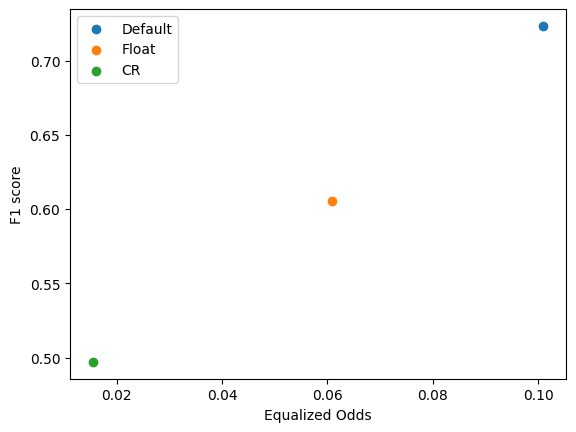

In [ ]:
# Default
pred = model.predict(X_test)
plt.scatter(equalized_odds_difference(y_test, pred, sensitive_features=X_test['sex']), f1_score(y_test, pred),  label='Default')
plt.legend()

# Float
pred = model_fl.predict(X_test_fl)
plt.scatter(equalized_odds_difference(y_test, pred, sensitive_features=X_test['sex']), f1_score(y_test, pred),  label='Float')
plt.legend()

# Correlation removal
pred = model_cr.predict(X_test_fl)
plt.scatter(equalized_odds_difference(y_test, pred, sensitive_features=X_test['sex']), f1_score(y_test, pred),  label='CR')
plt.legend()

plt.xlabel('Equalized Odds')
plt.ylabel('F1 score')
plt.show()

# おわりに

### 今回の結果
Correlation Removerによってモデルの公平性を改善できることが確認できました。  
しかし、F1スコアの低下が大きく、実用的なモデルとはなりませんでした。  


### 次にやること  
学習後に公平性を改善する手法も検証したいと思います。

### 参考資料
- Adult Data Set  
http://archive.ics.uci.edu/ml/datasets/adult
- Fairlearn  
https://fairlearn.org/v0.8/quickstart.html
